# Regularization in Linear Regression 
Car price prediction project

## Dataset

Dataset is the Car prices data from Kaggle.

Here's a wget-able [link](https://raw.githubusercontent.com/Ksyula/ML_Engineering/master/02-regression/car_price_data.csv)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
np.__version__, pd.__version__

('1.21.5', '1.4.3')

## Data preparation

In [3]:
data = pd.read_csv('car_price_data.csv')
data.shape

(11914, 16)

In [4]:
data.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [5]:
data.dtypes

Make                  object
Model                 object
Year                   int64
Engine Fuel Type      object
Engine HP            float64
Engine Cylinders     float64
Transmission Type     object
Driven_Wheels         object
Number of Doors      float64
Market Category       object
Vehicle Size          object
Vehicle Style         object
highway MPG            int64
city mpg               int64
Popularity             int64
MSRP                   int64
dtype: object

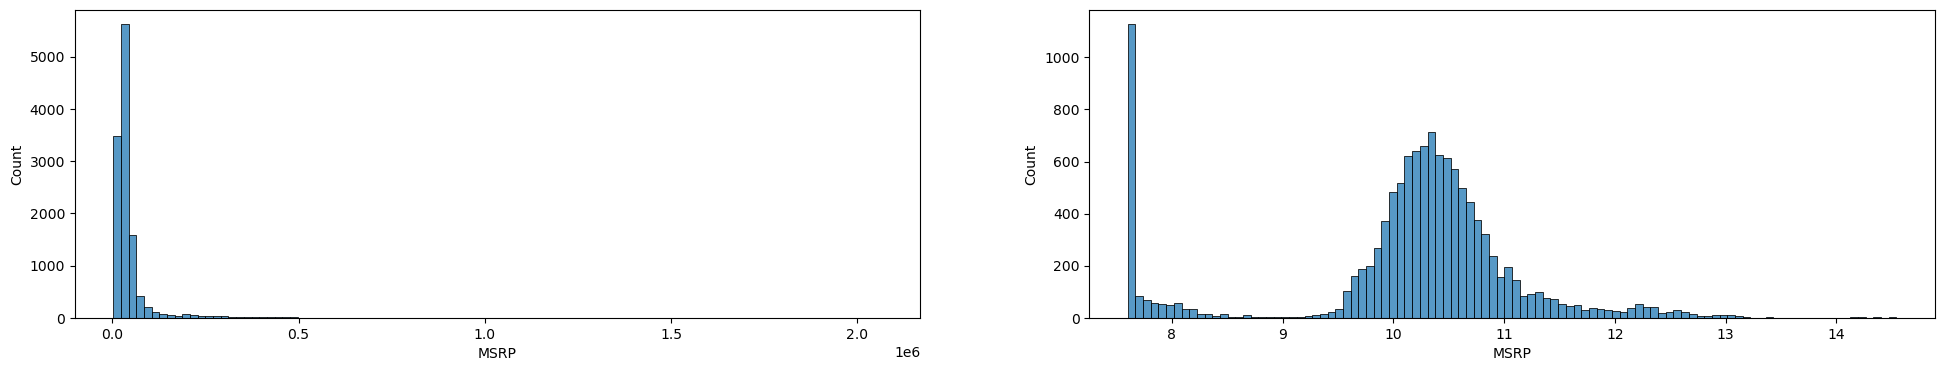

In [6]:
# Log transform target due to original long tail distribution
fig, ax = plt.subplots(1,2, figsize=(24, 4))
sns.histplot(data.MSRP, bins = 100, ax=ax[0])
sns.histplot(np.log1p(data.MSRP), bins = 100, ax=ax[1]) # log scale
plt.show()

In [7]:
def data_preparation(df):
    # lowercase and remove spaces in the header
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    # select only numerical variables
    num_cols = df.dtypes[(data.dtypes == ('float64')) | (df.dtypes == ('int64'))].index.tolist()
    # clean up categorical variables
    cat_cols = list(df.dtypes[df.dtypes == 'object'].index)
    for col in cat_cols:
        df[col] = df[col].str.lower().str.replace(' ', '_')
    # target log-transformtion
    df.msrp = np.log1p(df.msrp)
    return df, num_cols, cat_cols

data, num_cols, cat_cols = data_preparation(data)

data.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,10.739349
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,10.612779
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,10.500977
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,10.290483
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,10.448744


### Feature selection

In [8]:
# Select numerical variables
data = data[data.dtypes[(data.dtypes == 'float64') | (data.dtypes == 'int64')].index.tolist()]
data.head()

,year,engine_hp,engine_cylinders,number_of_doors,highway_mpg,city_mpg,popularity,msrp
0,2011,335.0,6.0,2.0,26,19,3916,10.739349
1,2011,300.0,6.0,2.0,28,19,3916,10.612779
2,2011,300.0,6.0,2.0,28,20,3916,10.500977
3,2011,230.0,6.0,2.0,28,18,3916,10.290483
4,2011,230.0,6.0,2.0,28,18,3916,10.448744


In [9]:
# convert year to the age of a car
data['age'] = max(data['year']) - data['year']
del data['year']
data.head()

,engine_hp,engine_cylinders,number_of_doors,highway_mpg,city_mpg,popularity,msrp,age
0,335.0,6.0,2.0,26,19,3916,10.739349,6
1,300.0,6.0,2.0,28,19,3916,10.612779,6
2,300.0,6.0,2.0,28,20,3916,10.500977,6
3,230.0,6.0,2.0,28,18,3916,10.290483,6
4,230.0,6.0,2.0,28,18,3916,10.448744,6


### Missing values imputation

In [10]:
data.isna().sum()

engine_hp           69
engine_cylinders    30
number_of_doors      6
highway_mpg          0
city_mpg             0
popularity           0
msrp                 0
age                  0
dtype: int64

In [11]:
data = data.fillna(0)

### Feature scaling

In [12]:
# Scale numerical variables
for f in ['engine_hp','engine_cylinders','number_of_doors','highway_mpg','city_mpg','popularity','age']:
    data[f] = (data[f] - min(data[f])) / (max(data[f]) - min(data[f]))
data.head()

,engine_hp,engine_cylinders,number_of_doors,highway_mpg,city_mpg,popularity,msrp,age
0,0.334665,0.375,0.5,0.040936,0.092308,0.692131,10.739349,0.222222
1,0.299700,0.375,0.5,0.046784,0.092308,0.692131,10.612779,0.222222
2,0.299700,0.375,0.5,0.046784,0.100000,0.692131,10.500977,0.222222
3,0.229770,0.375,0.5,0.046784,0.084615,0.692131,10.290483,0.222222
4,0.229770,0.375,0.5,0.046784,0.084615,0.692131,10.448744,0.222222


## Set up a validation framework
### Split the data

In [13]:
# Shuffle data with the rundom seed
def shuffle_dataset(random_seed, data):
    n = len(data)
    np.random.seed(random_seed)
    idx = np.arange(n)
    np.random.shuffle(idx)
    
    data_shuffled = data.iloc[idx].reset_index(drop=True)
    return data_shuffled

data = shuffle_dataset(42, data)

In [14]:
# Split data with the ratio 60/20/20
def split_data(data, n_val_perc, n_test_perc):
    n = len(data)
    n_val = int(n * n_val_perc)
    n_test = int(n * n_test_perc)
    n_train = n - n_val - n_test
    
    df_train = data.iloc[:n_train]
    df_val = data.iloc[n_train:n_train + n_val]
    df_test = data.iloc[n_train + n_val:]
    
    return df_train, df_val, df_test

df_train, df_val, df_test = split_data(data, 0.2, 0.2)

In [15]:
# Exclude target from train set
def remove_target_from_train(df_train, df_val, df_test, target_name):
    y_train = df_train[target_name]
    y_val = df_val[target_name]
    y_test = df_test[target_name]
    
    y_train = np.log1p(y_train)
    y_val = np.log1p(y_val)
    y_test = np.log1p(y_test)

    del df_train[target_name]
    del df_val[target_name]
    del df_test[target_name]
    
    return df_train, df_val, df_test, y_train, y_val, y_test

df_train, df_val, df_test, y_train, y_val, y_test = remove_target_from_train(df_train, df_val, df_test, 'msrp')

## Train Linear Regression model

In [16]:
def train_linear_regression(X, y):
    # transform input data from pandas DataFrame to numpy arrays
    X, y = np.array(X), np.array(y)
    ones = np.ones(X.shape[0])
    # append vector with all ones in the beginning of training matrix
    X = np.column_stack([ones, X])
    # train Linear Regression
    # 1. Calculate Gram matrix
    XTX = X.T.dot(X)
    # 2. Take inverse of Gram matrix
    XTX_inv = np.linalg.inv(XTX)
    # 3. Calculate weights vector w
    w = XTX_inv.dot(X.T).dot(y)
    return w

def apply_the_model(X, w):
    # transform input data from pandas DataFrame to numpy array
    X = np.array(X)
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    # make predictions
    y_pred = X.dot(w)
    return y_pred

def rmse(y_pred, y_true):
    assert(len(y_pred) == len(y_true))
    error = y_pred - y_true
    se = error ** 2
    mse = np.mean(se)
    rmse = np.sqrt(mse)
    return rmse

In [17]:
w = train_linear_regression(df_train, y_train)
y_pred = apply_the_model(df_val, w)
rmse(y_pred, y_val)

0.04946195014272296

## Introduce Regularization
Train Ridge Regression (L1-refularisation)

In [18]:
def train_linear_regression_w_reg(X, y, r):
    # transform input data from pandas DataFrame to numpy arrays
    X, y = np.array(X), np.array(y)
    ones = np.ones(X.shape[0])
    # append vector with all ones in the beginning of training matrix
    X = np.column_stack([ones, X])
    # train Linear Regression
    # 1. Calculate Gram matrix
    XTX = X.T.dot(X)
    # 2. Introduce regularization
    XTX = XTX + r * np.eye(XTX.shape[0])
    # 3. Take inverse of Gram matrix
    XTX_inv = np.linalg.inv(XTX)
    # 4. Calculate weights vector w
    w = XTX_inv.dot(X.T).dot(y)
    return w

In [19]:
for r in [0, 0.0001, 0.001, 0.01, .1, 1, 10]:
    w = train_linear_regression_w_reg(df_train, y_train, r)
    y_pred = apply_the_model(df_val, w)
    print(r, rmse(y_pred, y_val))

0 0.04946195014272296
0.0001 0.049461967974401055
0.001 0.0494621284569805
0.01 0.04946373304599409
0.1 0.049479768701835285
1 0.04964946458641827
10 0.053191116805667155
